# Strategy: Ranked by Volume Long-Short Portfolio

### Thomas Polstra, PhD

##### [GitHub](https://github.com/thomaspolstra/Quant_Materials_Polstra_Public.git) -- [Academic Website](https://thomaspolstra.github.io/) -- [Email](mailto:thomaspolstra@gmail.com)

The strategy involves creating a diversified long-short portfolio of $112$ randomly chosen stocks in the S&P 500 index. It starts by ranking the stocks based on their average trading volumes, selecting the top half of the stocks with the highest trading volumes to form the "long" portfolio. Simultaneously, the bottom half with the lowest trading volumes are selected to form the "short" portfolio.

For the "long" portfolio, the strategy invests an equal amount in each stock, purchasing as many shares of each stock as possible with an initial investment of $1000. This ensures a balanced allocation across all selected stocks.

For the "short" portfolio, the strategy aims to profit from a decline in the stock prices. It borrows shares of each shorted stock from a broker and sells them in the market. When the stock prices decrease, the strategy buys back the shares at a lower price, returning them to the broker, thus making a profit from the price difference.

The portfolio is then rebalanced periodically, typically on a daily basis. At each rebalancing point, the strategy calculates the returns of the long and short positions based on the percentage change in stock prices and updates the portfolio accordingly. It adjusts the position size of each stock to maintain an equal investment across all selected stocks, considering both long and short positions.

The strategy aims to profit from both upward and downward movements in the market while mitigating the impact of overall market fluctuations. It relies on the assumption that stocks with high trading volumes tend to be more liquid, potentially offering better opportunities for trading, while stocks with low trading volumes may exhibit greater price volatility, offering potential for short-selling gains.

The returns are then compared to the benchmark returns, which represent the daily returns of the S&P 500 index. The performance of the strategy is evaluated based on the Strategy Return, which represents the overall daily returns achieved by the portfolio.

### Performance Summary

This Python notebook presents the backtesting results of a six-month investment strategy from January 6, 2023, to July 31, 2023. Despite being an elementary strategy, the approach exhibits an annual return of 9.937% with a Sharpe ratio of 2.23, indicating favorable risk-adjusted performance, during the testing period. The strategy's stability is reflected in a low annual volatility of 4.299% and a Calmar ratio of 5.13, highlighting its ability to recover from losses efficiently.

The strategy has a more favorable risk profile and did better at retaining profits when compared to the S&P500 index, but had less returns overall during the testing period. 

See [below](#target) for a full tear sheet and analysis of the strategy.

### Ideas for Improvement

1. **Enhance Asset Ranking Scheme**: To improve the strategy's performance, consider refining the asset ranking scheme. A more sophisticated ranking approach could potentially enhance the strategy's ability to identify high-potential assets.

2. **Specialize in Specific Asset Classes**: Explore the possibility of customizing the strategy to focus on specific asset classes or a limited number of sectors. For instance, consider developing strategies that short stocks in one sector while going long on stocks in another sector. Balancing the distribution of longs and shorts across various asset classes could lead to additional opportunities.

3. **Leverage Trading Optimization**: Given the consistent returns and relatively low risk observed during the testing period, optimizing the strategy by trading on leverage might help maximize profits relative to its inherent risk.

By implementing these enhancements, we can build upon the simplicity of the current strategy and explore numerous possibilities to further improve its performance and adaptability in different market conditions.

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import pyfolio as pf

In [2]:
# List of popular stocks
stocks = ['TSLA', 'AMD', 'AMZN', 'AAPL', 'NVDA', 'BAC', 'T', 
                  'INTC', 'GOOGL', 'MSFT', 'PFE', 'GOOG', 'META', 'VZ', 
                  'WFC', 'CSCO', 'CMCSA', 'PYPL', 'USB', 'XOM', 'DIS', 
                  'KO', 'SCHW', 'CSX', 'ORCL', 'JPM', 'CVS', 'QCOM', 'BMY', 
                  'NKE', 'CVX', 'JNJ', 'NEE', 'NFLX', 'MRK', 'MO', 'SBUX', 
                  'CRM', 'MDLZ', 'PG', 'V', 'AMAT', 'ABBV', 'TGT', 'GILD', 'WMT', 
                  'RTX', 'BA', 'CL', 'TXN', 'MDT', 'FIS', 'PEP', 'ABT', 'IBM', 
                  'PM', 'HD', 'SO', 'ADBE', 'MMM', 'D', 'UNH', 'UPS', 'DHR', 'PGR', 
                  'COF', 'AVGO', 'AXP', 'CCI', 'CAT', 'MA', 'DUK', 'LOW', 'UNP', 
                  'AMGN', 'ACN', 'HON', 'SYY', 'MCD', 'GS', 'AMT', 'ICE', 'ZTS', 
                  'FDX', 'CB', 'INTU', 'COST', 'ADP', 'KMB', 'DE', 'TMO', 'ISRG', 
                  'CI', 'ILMN', 'ADSK', 'LIN', 'CME', 'NOW', 'WM', 'SYK', 'SPGI', 
                  'BDX', 'CHTR', 'STZ', 'LMT', 'APD', 'AON', 'REGN', 'BLK', 'EQIX', 'BKNG', 'CMG']
stocks_SP = ['TSLA', 'AMD', 'AMZN', 'AAPL', 'NVDA', 'BAC', 'T', 
                  'INTC', 'GOOGL', 'MSFT', 'PFE', 'GOOG', 'META', 'VZ', 
                  'WFC', 'CSCO', 'CMCSA', 'PYPL', 'USB', 'XOM', 'DIS', 
                  'KO', 'SCHW', 'CSX', 'ORCL', 'JPM', 'CVS', 'QCOM', 'BMY', 
                  'NKE', 'CVX', 'JNJ', 'NEE', 'NFLX', 'MRK', 'MO', 'SBUX', 
                  'CRM', 'MDLZ', 'PG', 'V', 'AMAT', 'ABBV', 'TGT', 'GILD', 'WMT', 
                  'RTX', 'BA', 'CL', 'TXN', 'MDT', 'FIS', 'PEP', 'ABT', 'IBM', 
                  'PM', 'HD', 'SO', 'ADBE', 'MMM', 'D', 'UNH', 'UPS', 'DHR', 'PGR', 
                  'COF', 'AVGO', 'AXP', 'CCI', 'CAT', 'MA', 'DUK', 'LOW', 'UNP', 
                  'AMGN', 'ACN', 'HON', 'SYY', 'MCD', 'GS', 'AMT', 'ICE', 'ZTS', 
                  'FDX', 'CB', 'INTU', 'COST', 'ADP', 'KMB', 'DE', 'TMO', 'ISRG', 
                  'CI', 'ILMN', 'ADSK', 'LIN', 'CME', 'NOW', 'WM', 'SYK', 'SPGI', 
                  'BDX', 'CHTR', 'STZ', 'LMT', 'APD', 'AON', 'REGN', 'BLK', 'EQIX', 'BKNG', 'CMG', '^GSPC']

# Create an empty dictionary to store stock symbols and their traded volumes
stock_volumes = {}

# Fetch stock data and calculate average trading volume for each stock
for symbol in stocks:
    try:
        stock_data = yf.Ticker(symbol)
        avg_volume = stock_data.info.get('averageVolume')
        if avg_volume:
            stock_volumes[symbol] = avg_volume
        else:
            print(f"Unable to get average volume for {symbol}. Skipping...")
    except Exception as e:
        print(f"Error occurred while fetching data for {symbol}: {str(e)}")

# Sort the stocks based on traded volume in descending order
sorted_stocks_by_volume = sorted(stock_volumes.items(), key=lambda x: x[1], reverse=True)


# identify stocks to short
n = len(sorted_stocks_by_volume)
m = int(n/2)

short_stocks = []
    
for i in range(m,n):
    short_stocks.append(sorted_stocks_by_volume[i][0])

    
# Date for which you want to get the price info
date = "2023-01-03"
date1 = "2023-01-04"

stock_data = yf.download(stocks_SP, start = date, end = date1)



# Assuming you have the DataFrame 'stock_data' with the MultiIndex columns as described
# and 'stocks' is a list of tickers you want to associate with their 'Close' prices.

# Create an empty dictionary to store the results
ticker_close_dict = {}

# Loop through the 'stocks' list and extract the 'Close' price for each ticker
for ticker in stocks:
    try:
        close_price = stock_data['Adj Close', ticker].iloc[0]  # Extract the first (and only) element from the Series
        ticker_close_dict[ticker] = close_price
    except KeyError:
        print(f"Close price not available for {ticker}. Skipping...")
        
number_of_stocks_to_buy_short = {}

for ticker in stocks:
    number_of_stocks_to_buy_short[ticker] = int(1000/ticker_close_dict[ticker])
    
amount_invested = {}
total_amount_invested = 0
for ticker in stocks:
    x = number_of_stocks_to_buy_short[ticker]*ticker_close_dict[ticker]
    amount_invested[ticker] = x 
    total_amount_invested += x

    
# Define start and end dates
start_date = "2023-01-04"
end_date = "2023-08-01"

# Download the stock data for the specified date range
future_stock_data = yf.download(stocks_SP, start=start_date, end=end_date)

# Create a new DataFrame to store the returns
returns_df = pd.DataFrame()

# Calculate the daily percentage change (returns) for each stock symbol and add it to the returns DataFrame
for ticker in stocks_SP:
    try:
        # Get the 'Adj Close' prices for the stock
        close_prices = future_stock_data['Adj Close'][ticker]

        # Calculate the daily percentage change using pct_change()
        returns = close_prices.pct_change()

        # Adjust the percentage by a minus sign if the stock is in the short_stocks list
        if ticker in short_stocks:
            returns = -returns

        # Store the returns in a temporary DataFrame with column name "Return (SYMBOL)"
        temp_df = pd.DataFrame({f'{ticker}': returns})

        # Concatenate the temporary DataFrame with the main returns DataFrame
        returns_df = pd.concat([returns_df, temp_df], axis=1)

    except KeyError:
        print(f"Data not available for {ticker}. Skipping...")

returns_df = returns_df.dropna()

#Keep track of each individual long/short investment
invested = amount_invested.copy()

# Calculate the total amount invested
total_amount_invested = sum(invested[stock] for stock in stocks)

# Create a copy of the DataFrame to avoid the SettingWithCopyWarning
returns_df_copy = returns_df.copy()

# Loop through the DataFrame and calculate the Strategy_Value for each date
for day in returns_df_copy.index[1:]:
    for stock in stocks:
        invested[stock] = invested[stock] * (1 + returns_df_copy.loc[day, stock])
    
    total = sum(invested[stock] for stock in stocks)
    returns_df_copy.loc[day, 'Strategy_Value'] = total

# After the loop completes, set the 'Strategy_Value' for the first date
returns_df_copy.loc[returns_df_copy.index[0], 'Strategy_Value'] = total_amount_invested

#We now have our strategy returns
returns_df_copy['Strategy_Return'] = returns_df_copy['Strategy_Value'].pct_change()

strat_returns = returns_df_copy['Strategy_Return'].dropna()

benchmark_returns = returns_df_copy['^GSPC'][1:]

[*********************100%***********************]  113 of 113 completed
[*********************100%***********************]  113 of 113 completed


Start date,2023-01-06
End date,2023-07-31
Total months,6
,Backtest
Annual return,9.937%
Cumulative returns,5.444%
Annual volatility,4.299%
Sharpe ratio,2.23
Calmar ratio,5.13
Stability,0.82
Max drawdown,-1.937%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,1.94,2023-02-07,2023-03-13,2023-05-15,70
1,1.13,2023-07-19,2023-07-26,NaT,NaN
2,1.07,2023-06-20,2023-06-26,2023-07-13,18
3,0.76,2023-05-30,2023-06-07,2023-06-12,10
4,0.36,2023-01-06,2023-01-11,2023-01-17,8


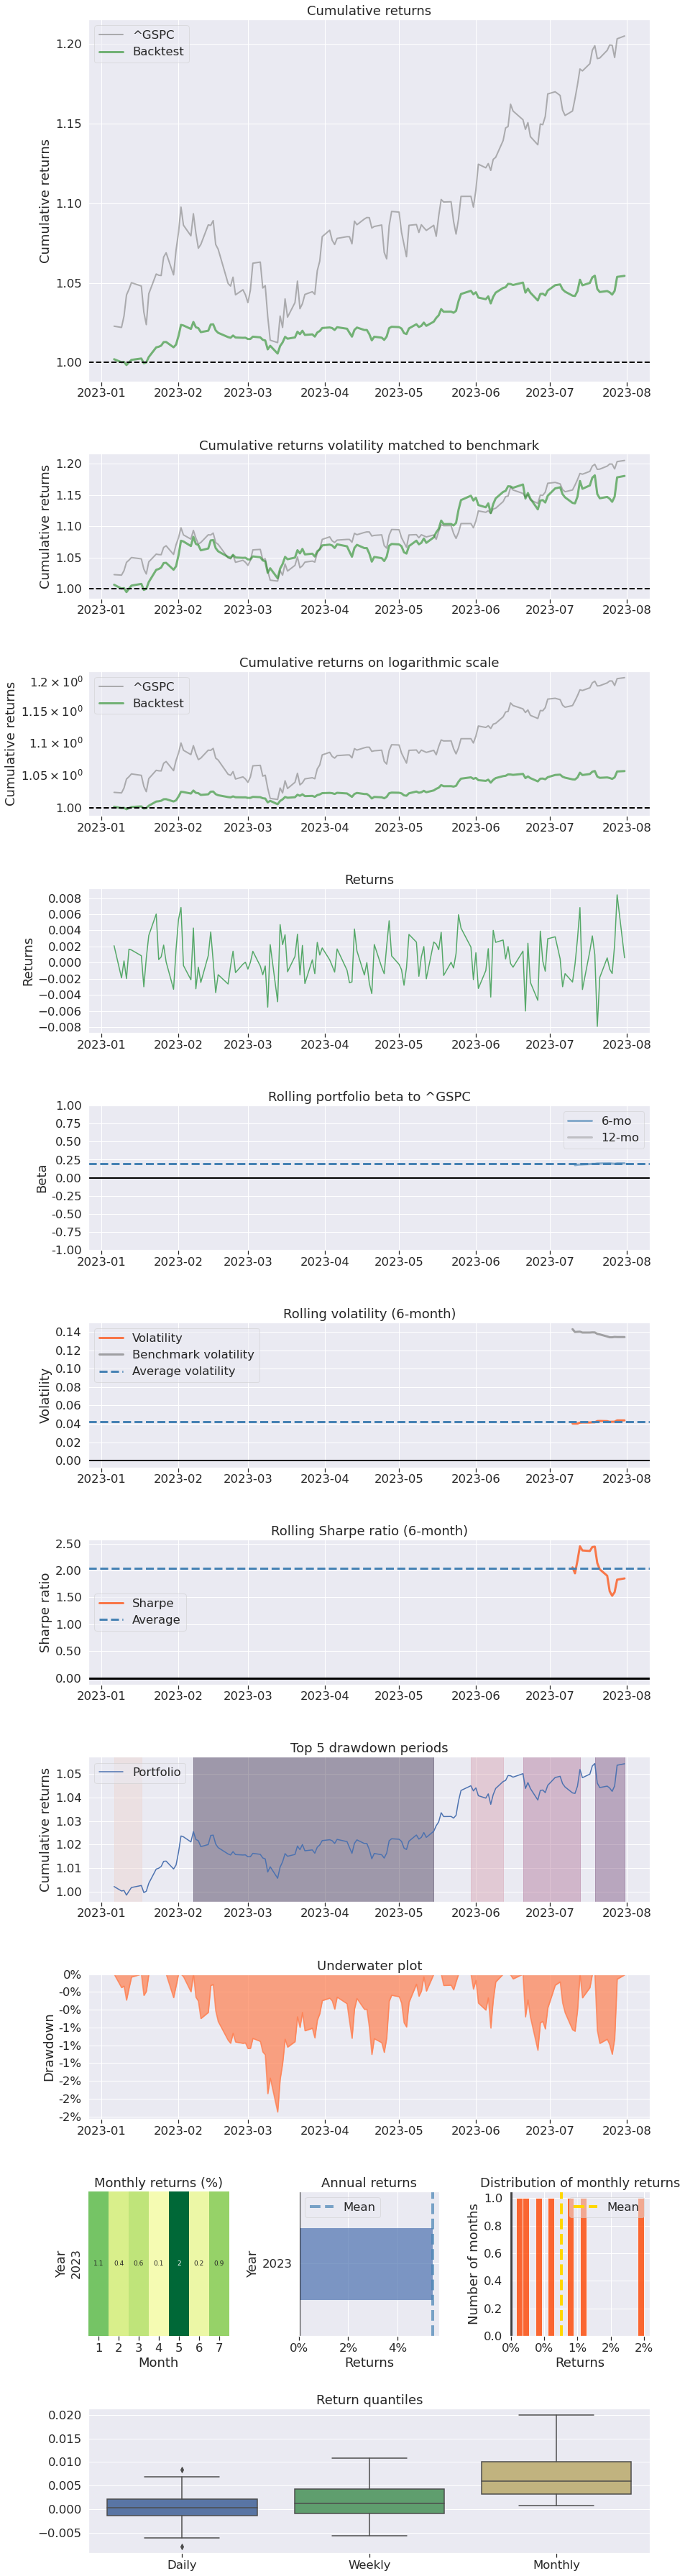

In [3]:
pf.create_returns_tear_sheet(strat_returns, benchmark_rets=benchmark_returns)

## Backtesting Statistics
<a id="target"></a>

### Backtest Period
- Start Date: 2023-01-06
- End Date: 2023-07-31
- Total Months: 6

### Performance Metrics
- Annual Return: 9.937%
- Cumulative Returns: 5.444%
- Annual Volatility: 4.299%
- Sharpe Ratio: 2.23
- Calmar Ratio: 5.13
- Stability: 0.82
- Max Drawdown: -1.937%
- Omega Ratio: 1.43
- Sortino Ratio: 3.59
- Skew: 0.07
- Kurtosis: 0.38
- Tail Ratio: 1.27
- Daily Value at Risk: -0.504%
- Alpha: 0.03
- Beta: 0.19

#### Commentary on Values:

- **Annual Return: 9.937%**
  - A higher value: An annual return of 9.937% indicates a relatively strong average annualized gain during the backtest period. This value is significant as it shows the strategy's ability to generate positive returns over the long term.

- **Cumulative Returns: 5.444%**
  - A value close to 0: The cumulative returns of 5.444% indicate a moderate growth of the investment over the entire 6-month period. While positive, the value is not significantly high, and it may be essential to consider the longer-term performance of the strategy.

- **Annual Volatility: 4.299%**
  - A relatively low value: An annual volatility of 4.299% suggests relatively low fluctuations in returns over the year. This is significant as it indicates that the strategy is relatively stable and may appeal to risk-averse investors.

- **Sharpe Ratio: 2.23**
  - A higher value: A Sharpe ratio of 2.23 indicates a strong risk-adjusted return, where the strategy generates superior returns relative to the risk taken. This value is significant as it suggests favorable risk-adjusted performance.

- **Calmar Ratio: 5.13**
  - A higher value: The Calmar ratio of 5.13 suggests that the strategy has achieved substantial returns relative to its maximum drawdown. This is significant as it demonstrates the strategy's ability to recover from losses.

- **Stability: 0.82**
  - A value close to 1: The stability value of 0.82 indicates that the strategy has demonstrated relatively consistent performance during the backtest period. A value close to 1 is significant as it suggests a steady and predictable return pattern.

- **Max Drawdown: -1.937%**
  - A negative value: The maximum drawdown of -1.937% represents the peak-to-trough decline in the strategy's value during the period. While negative, the drawdown is relatively small, indicating limited losses experienced by the strategy.

- **Omega Ratio: 1.43**
  - A higher value: An Omega ratio of 1.43 suggests that the strategy generates more significant returns compared to its downside risk. This is significant as it indicates favorable risk-adjusted returns.

- **Sortino Ratio: 3.59**
  - A higher value: The Sortino ratio of 3.59 indicates strong risk-adjusted returns, focusing on minimizing downside risk. This value is significant as it suggests favorable performance during adverse market conditions.

- **Skew: 0.07**
  - A value close to 0: A skewness value of 0.07 suggests a nearly symmetrical return distribution. While not exactly zero, the value indicates a relatively balanced return distribution.

- **Kurtosis: 0.38**
  - A value close to 0: A kurtosis value of 0.38 indicates a nearly normal distribution of returns. While not exactly zero, the value suggests that the strategy's return distribution is not overly peaked or flat.

- **Tail Ratio: 1.27**
  - A higher value: The tail ratio of 1.27 indicates that the strategy's upside returns are higher than its downside returns. A higher value is significant as it suggests a more favorable skewness in returns.

- **Daily Value at Risk: -0.504%**
  - A negative value: The daily value at risk of -0.504% represents the potential loss the strategy could incur at a given level of confidence over a single day. A negative value indicates that the strategy is expected to experience limited daily losses.

- **Alpha: 0.03**
  - A positive value: An alpha of 0.03 indicates the strategy's risk-adjusted outperformance relative to its benchmark. While positive, the value is relatively small, and it may be essential to consider the statistical significance of alpha.

- **Beta: 0.19**
  - A value less than 1: A beta value of 0.19 suggests that the strategy is less volatile than the benchmark index. A value less than 1 indicates that the strategy is expected to exhibit lower sensitivity to market movements.

Overall, these backtesting statistics provide valuable insights into the performance and risk profile of the investment strategy.

## Risk Profile of Investment Strategy

The investment strategy exhibits a balanced risk profile, focusing on generating favorable risk-adjusted returns while maintaining relative stability during the backtest period. Key risk profile attributes include:

### Volatility
The strategy demonstrates relatively low volatility, as indicated by an annual volatility of 4.299%. This suggests that the investment's day-to-day fluctuations are modest, making it potentially appealing to risk-averse investors.

### Drawdowns
The maximum drawdown is -1.937%, representing the largest peak-to-trough decline experienced during the backtest period. This indicates that the strategy has managed to limit losses, minimizing downside risk for investors.

### Risk-Adjusted Returns
The strategy exhibits favorable risk-adjusted returns, as evidenced by a Sharpe ratio of 2.23 and a Sortino ratio of 3.59. These ratios measure the investment's ability to generate superior returns compared to the risk taken, especially during adverse market conditions.

### Performance Consistency
The stability value of 0.82 suggests that the strategy has demonstrated relatively consistent performance during the backtest period. This indicates that the investment maintains a steady and predictable return pattern over time.

### Downside Protection
The Calmar ratio of 5.13 highlights the strategy's ability to recover from losses effectively. This provides some assurance to investors that the investment can bounce back from challenging market conditions.

### Tail Risk
The tail ratio of 1.27 suggests that the strategy's upside returns are higher than its downside returns, indicating a more favorable skewness in returns. This attribute can be desirable for investors seeking potentially higher rewards with limited downside exposure.

### Benchmark Performance
The strategy's Alpha of 0.03 suggests a slight risk-adjusted outperformance relative to the benchmark index. The Beta of 0.19 indicates that the investment is less volatile than the benchmark, showcasing lower sensitivity to market movements.

In summary, the investment strategy appears to strike a balance between generating attractive returns and managing risk effectively. It exhibits a relatively stable performance, favorable risk-adjusted returns, and limited downside risk, making it potentially suitable for investors with low-risk appetites.